In [1]:
%load_ext autoreload
%autoreload 2
from sound_field import SoundField,SoundFieldDataset,divide_to_subbands,divide_to_time_windows
from signal_info import signal_info
from optimizer import optimizer
from optimizer_v2 import optimizer_v2
from DoA_est import DoA_via_bands
import utils
import numpy as np
import math
import time
import torch
import gc
import os
from collections import defaultdict,Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time



LEBEDEV = 'lebedev'
POINTS_162 = '162_points'
SQP_OPT_METHOD = "SQP"
GD_DEEP_OPT_METHOD = "GD_Deep"
GD_OPT_METHOD = "GD_lagrange_multi" #GD_Deep GD_lagrange_multi
SLS_OPT_METHOD = "SLS"
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")
torch.cuda.empty_cache()  # Free up unused memory on GPU
gc.collect()  # Clean up unused memory on CPU


Device Name: NVIDIA GeForce RTX 4080 SUPER


61

In [2]:
data_set = torch.load(r"data\WSJ0\Dataset_03_01_25.pt",weights_only=False)

In [54]:
train_set = SoundFieldDataset(data_set['train'],DEVICE)
val_set = SoundFieldDataset(data_set['validation'],DEVICE)
test_set = SoundFieldDataset(data_set['test'],DEVICE)

In [4]:
train_set.__dict__.keys()

dict_keys(['data', 'device', 'input_order', 'upscaled_order', 'num_bins', 'window_length', 'max_num_windows', 'min_num_speakers', 'max_num_speakers', 'min_theta', 'max_theta', 'min_phi', 'max_phi', 'min_dist', 'sr', 'grid_type', 'P_th', 'P_ph'])

In [55]:
batch_size = 1
num_epochs = 100

down_sample = 1
num_bins = 45

window_length = 1024
max_num_windows = int(1e10)

mask = None

train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=True)
test_data_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True)

Y_p = utils.create_sh_matrix(train_set.input_order, zen=train_set.P_th, azi=train_set.P_ph).to(DEVICE)
Y_p_tag = utils.create_sh_matrix(3, zen=train_set.P_th, azi=train_set.P_ph).to(DEVICE) # upscaling matrix (TODO ADD UPSCALE ORDER TO DATASET INFO)
opt_model = optimizer_v2(Y_p=Y_p,alpha=0.01,num_iters=2500,device=DEVICE,num_bins=train_set.num_bins,deep_unfolded=False)

optimizer = torch.optim.Adam(opt_model.parameters(), lr=1e-3)



In [6]:
def preprocess_batch(batch, num_bins, down_sample, window_length, max_num_windows,sr):
    a_nmt_subbands = divide_to_subbands(batch[0], num_bins=num_bins, downsample=down_sample, sr=sr)
    a_nmt_subbands_windowed = divide_to_time_windows(a_nmt_subbands,window_length=window_length, max_num_windows=max_num_windows)

    gt_a_nmt_subbands = divide_to_subbands(batch[1], num_bins=num_bins, downsample=down_sample,sr=sr)
    gt_a_nmt_subbands_windowed = divide_to_time_windows(anm_t_subbands=gt_a_nmt_subbands,window_length=window_length, max_num_windows=max_num_windows)
    print("Finished Preprocessing")
    return a_nmt_subbands_windowed,gt_a_nmt_subbands_windowed

In [7]:
def loss_func(pred,gt):
    #Take only new coefficients
    pred_high_order_coeff=pred[:,:,:,:(train_set.input_order+1)**2]
    gt_high_order_coeff = gt[:,:,:,:(train_set.input_order+1)**2:]
    return torch.sum((pred_high_order_coeff-gt_high_order_coeff)**2)/pred_high_order_coeff.shape[0] #Normalize by number of windows

100%|██████████| 2500/2500 [00:35<00:00, 70.18it/s]


A tensor(5.9315, device='cuda:0')


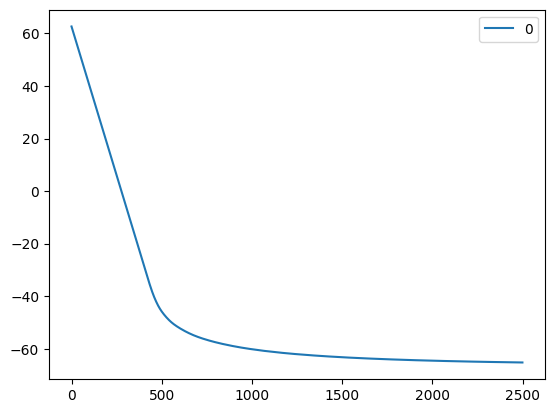

In [63]:
#Normalization?
with torch.no_grad():
    for epoch in range(num_epochs):
        loss = 0 
        for i,batch in enumerate(train_data_loader):
            low_order_anmt,high_order_anmt,audio_id = batch
            a_nmt_subbands = divide_to_subbands(low_order_anmt, num_bins=num_bins, downsample=down_sample, sr=train_set.sr)
            a_nmt_subbands_windowed = divide_to_time_windows(a_nmt_subbands,window_length=window_length, max_num_windows=max_num_windows)
            gt_a_nmt_subbands = divide_to_subbands(high_order_anmt, num_bins=num_bins, downsample=down_sample,sr=train_set.sr)
            gt_a_nmt_subbands_windowed = divide_to_time_windows(anm_t_subbands=gt_a_nmt_subbands,window_length=window_length, max_num_windows=max_num_windows)
            est_sparse_dict_subbands = opt_model.forward(a_nmt_subbands_windowed,mask).permute(0,1,3,2) #change to (#Windows,#Bands,WindowLength,P)
            plt.plot(opt_model.low_dim_reconstruction_loss_per_iter,label=i)
            est_upscaled_subbands_windowed = torch.matmul(est_sparse_dict_subbands,Y_p_tag.t())
            print("A",10*torch.log10(torch.norm((est_upscaled_subbands_windowed[:,:,:,:4] - gt_a_nmt_subbands_windowed[:,:,:,:4]),p=2)**2))
            # est_upscaled_subbands_windowed = torch.matmul(est_sparse_dict_subbands,Y_p_tag.t())
            # loss += loss_func(est_upscaled_subbands_windowed,gt_a_nmt_subbands_windowed)
            # # if i % 10 == 0 and i>0:
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            # print(loss)
            # # Detach loss to free computational graph
            # loss.detach_()
            # # Clear cache (optional)
            # torch.cuda.empty_cache()
            # loss = 0 
            break
        break
    plt.legend()


        




In [71]:
print(window,10*torch.log10(torch.norm((est_upscaled_subbands_windowed[0:97,:,:,:4] - gt_a_nmt_subbands_windowed[0:97,:,:,:4]),p=2)**2))

200 tensor(-53.8587, device='cuda:0')


Text(0.5, 1.0, 'Window 103 MSE per Band')

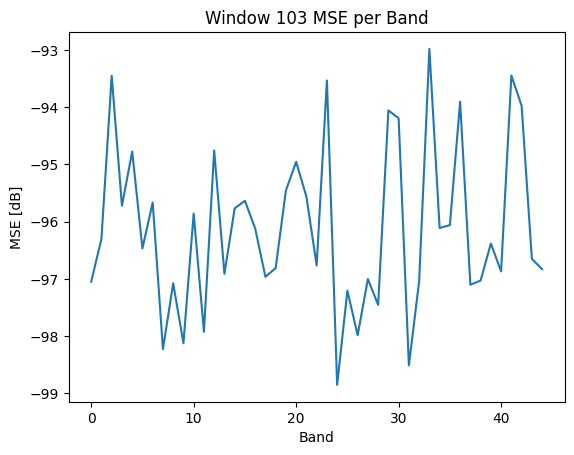

In [87]:
a = list()
for i in range(0,45):
    a.append(10*torch.log10(torch.norm((est_upscaled_subbands_windowed[50:51,i:i+1,:,:4] - gt_a_nmt_subbands_windowed[50:51,i:i+1,:,:4]),p=2)**2).detach().cpu().numpy())

plt.plot(a)
plt.xlabel("Band")
plt.ylabel("MSE [dB]")
plt.title("Window 103 MSE per Band")


In [64]:
for window in range(est_sparse_dict_subbands.shape[0]-1):
    print(window,10*torch.log10(torch.norm((est_upscaled_subbands_windowed[window:window+1,:,:,:4] - gt_a_nmt_subbands_windowed[window:window+1,:,:,:4]),p=2)**2))


0 tensor(-65.9658, device='cuda:0')
1 tensor(-58.4987, device='cuda:0')
2 tensor(-77.1651, device='cuda:0')
3 tensor(-65.4107, device='cuda:0')
4 tensor(-81.1624, device='cuda:0')
5 tensor(-72.4013, device='cuda:0')
6 tensor(-74.9132, device='cuda:0')
7 tensor(-79.6098, device='cuda:0')
8 tensor(-74.7672, device='cuda:0')
9 tensor(-76.8538, device='cuda:0')
10 tensor(-82.1055, device='cuda:0')
11 tensor(-78.6505, device='cuda:0')
12 tensor(-78.0683, device='cuda:0')
13 tensor(-80.4850, device='cuda:0')
14 tensor(-77.9915, device='cuda:0')
15 tensor(-77.4628, device='cuda:0')
16 tensor(-75.8686, device='cuda:0')
17 tensor(-78.9274, device='cuda:0')
18 tensor(-73.1344, device='cuda:0')
19 tensor(-78.2538, device='cuda:0')
20 tensor(-76.3837, device='cuda:0')
21 tensor(-77.6024, device='cuda:0')
22 tensor(-76.3761, device='cuda:0')
23 tensor(-80.1373, device='cuda:0')
24 tensor(-74.5845, device='cuda:0')
25 tensor(-76.3403, device='cuda:0')
26 tensor(-78.4778, device='cuda:0')
27 tensor(-

In [22]:
est_upscaled_subbands_windowed.shape

torch.Size([115, 45, 1024, 16])

100%|██████████| 5/5 [00:00<00:00, 301.69it/s]


tensor(25808.6367, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 5/5 [00:00<?, ?it/s]


tensor(25703.6816, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 5/5 [00:00<00:00, 301.19it/s]


tensor(25848.1719, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 5/5 [00:00<00:00, 768.47it/s]


tensor(25850.7930, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 5/5 [00:00<00:00, 320.00it/s]


tensor(25812.1348, device='cuda:0', grad_fn=<DivBackward0>)


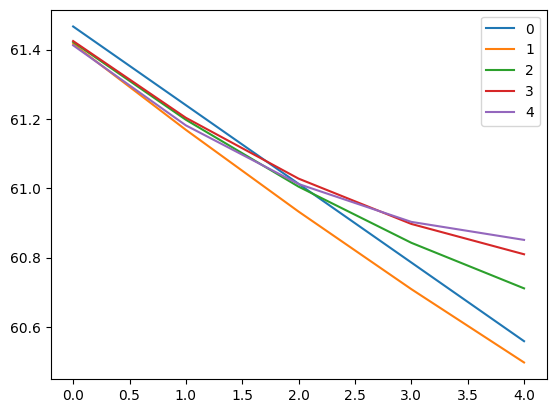

In [18]:
opt_model.num_iters = 5
for ii in range(5):
    est_sparse_dict_subbands = opt_model.forward(est_upscaled_subbands_windowed[:,:,:,:4],mask).permute(0,1,3,2) #change to (#Windows,#Bands,WindowLength,P)
    plt.plot(opt_model.low_dim_reconstruction_loss_per_iter,label=ii)
    learned_est_upscaled_subbands_windowed = torch.matmul(est_sparse_dict_subbands,Y_p_tag.t())
    loss = loss_func(learned_est_upscaled_subbands_windowed,gt_a_nmt_subbands_windowed)
    # if i % 10 == 0 and i>0:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)
    # Detach loss to free computational graph
    loss.detach_()
    # Clear cache (optional)
    torch.cuda.empty_cache()
    loss = 0 
plt.legend()

In [20]:
opt_model.__dict__['_parameters']['learned_mu']


Parameter containing:
tensor([[[[[0.0042]],

          [[0.0216]],

          [[0.0223]],

          ...,

          [[0.0042]],

          [[0.0228]],

          [[0.0042]]]],



        [[[[0.0042]],

          [[0.0225]],

          [[0.0226]],

          ...,

          [[0.0042]],

          [[0.0229]],

          [[0.0042]]]],



        [[[[0.0042]],

          [[0.0225]],

          [[0.0230]],

          ...,

          [[0.0042]],

          [[0.0227]],

          [[0.0042]]]],



        ...,



        [[[[0.0042]],

          [[0.0229]],

          [[0.0229]],

          ...,

          [[0.0042]],

          [[0.0229]],

          [[0.0042]]]],



        [[[[0.0042]],

          [[0.0229]],

          [[0.0229]],

          ...,

          [[0.0042]],

          [[0.0229]],

          [[0.0042]]]],



        [[[[0.0042]],

          [[0.0229]],

          [[0.0229]],

          ...,

          [[0.0042]],

          [[0.0229]],

          [[0.0042]]]]], device='cuda:0',

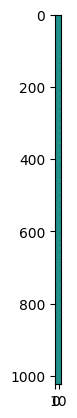

In [ ]:
plt.imshow(gt_a_nmt_subbands_windowed[0,40,:,:].cpu().numpy())